In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
#!git clone https://github.com/opendp/smartnoise-sdk

In [3]:
#pip install --editable smartnoise-sdk/synth

In [5]:
#!pip install diffprivlib

In [2]:
# from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer
from snsynth import MWEMSynthesizer
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN
from snsynth.pytorch.nn import PATECTGAN

from diffprivlib.models import LogisticRegression as DPLR

# 4. ACS Income Dataset

## 4.1 Non-private data processing

In [3]:
# Read in the original data
#adult_data_full = pd.read_csv('ACSIncome_clean.csv', index_col=False)
#adult_data_full.head()

# Read in sample directly
adult_data = pd.read_csv('acs_income_data_sample.csv', index_col=False)

In [4]:
# Take sample because this dataset is huge
#adult_data = adult_data_full.sample(n=30000, replace=False, random_state=1)

# Don't need this - reading sample in directly now

In [5]:
def process_adult_new(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["native_country", "Unnamed: 0"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["race", "occupation", "marital", "education", "workclass", "relationship"]
    df['race'] = pd.factorize(df['race'])[0]
    df['occupation'] = pd.factorize(df['occupation'])[0]
    df['marital'] = pd.factorize(df['marital'])[0]
    df['education'] = pd.factorize(df['education'])[0]
    df['workclass'] = pd.factorize(df['workclass'])[0]
    df['relationship'] = pd.factorize(df['relationship'])[0]

    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    df["over_under_50k"] = df["label"]

    return df

In [6]:
# Get the processed replacement adult data
processed_adult = process_adult_new(adult_data)
processed_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship,gender_labs,over_under_50k
0,1,0,0,40.0,0,0,0,0,41.0,0,Female,1
1,0,0,0,25.0,1,0,1,0,19.0,1,Female,0
2,0,0,0,20.0,2,0,0,0,41.0,2,Female,0
3,0,0,0,25.0,3,1,1,0,56.0,0,Female,0
4,0,1,1,40.0,4,2,1,0,25.0,1,Male,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,40.0,19,1,5,0,64.0,4,Male,1
29996,1,0,0,40.0,17,0,0,0,37.0,0,Female,1
29997,1,0,0,30.0,7,0,5,2,62.0,2,Female,1
29998,0,0,1,40.0,17,2,4,4,27.0,11,Male,0


In [7]:
# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
X_train.head()

,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
3225,0,1,50.0,7,1,2,0,47.0,4
11815,0,1,48.0,12,0,6,0,50.0,0
7338,0,0,40.0,7,0,5,3,67.0,2
14980,0,0,40.0,20,0,8,0,54.0,0
27167,0,1,45.0,11,2,6,7,57.0,0


In [9]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [10]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs = axs.ravel()
        axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
        axs[0].set_ylabel("TPR")
        axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
        axs[1].set_ylabel("FPR")
        fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

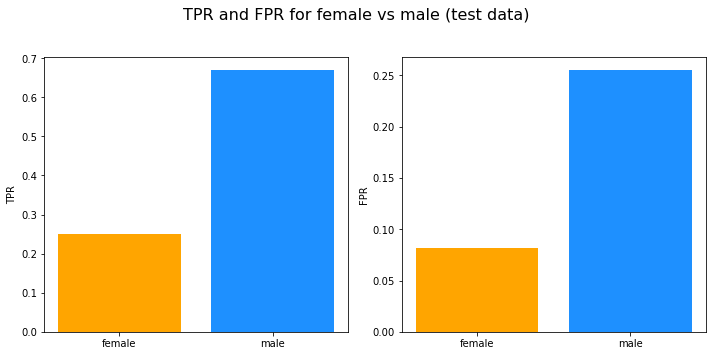

In [11]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f_non_priv, TPR_m_non_priv, FPR_f_non_priv, FPR_m_non_priv = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [12]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff_non_priv = TPR_m_non_priv-TPR_f_non_priv

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff_non_priv = FPR_m_non_priv-FPR_f_non_priv

# Demographic parity (FP + TP rate difference)
dem_parity_non_priv = (FPR_m_non_priv+TPR_m_non_priv)-(FPR_f_non_priv+TPR_f_non_priv)

# Calculate overall accuracy for female and male
ACC_f_non_priv = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m_non_priv = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff_non_priv:.4f}") # second
print(f"The difference in FPR (equalized odds) is: {FPR_diff_non_priv:.4f}") # first
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity_non_priv:.4f}")
print(f"The overall accuracy for female is: {ACC_f_non_priv:.4f}")
print(f"The overall accuracy for male is: {ACC_m_non_priv:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.4190
The difference in FPR (equalized odds) is: 0.1741
The difference in FP + TP rate (Demographic Parity) is: 0.5931
The overall accuracy for female is: 0.7151
The overall accuracy for male is: 0.7127


## 4.2 MWEM

### 4.2.1 Data preparation

Based on multiplicative weight update mechanism; requires binning of continuous data.

In [13]:
# Recombine X_train and y_train for synthesis
adult_train = pd.concat([X_train, y_train], axis=1)

# Recombine X_test and y_test for synthesis
adult_test = pd.concat([X_test, y_test], axis=1)

### 4.2.2 Varying $\varepsilon$

In [14]:
def get_synthesizer(synthesizer, epsilon):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
        splits=[], split_factor=2, max_bin_count=400)

    elif synthesizer == "DPCTGAN":
        synth = PytorchDPSynthesizer(epsilon=epsilon, gan=DPCTGAN(), preprocessor=None)
        
    elif synthesizer == "PATECTGAN":
        return PytorchDPSynthesizer(epsilon = epsilon, gan = PATECTGAN(regularization='dragan'), preprocessor = None)

    return synth

In [15]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate a synthesizer
    if synthesizer == "MWEM":
        def QuailSynth(epsilon):
            return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
        
    elif synthesizer == "DPCTGAN":
        def QuailSynth(epsilon):
            return PytorchDPSynthesizer(epsilon=epsilon, gan=DPCTGAN(), preprocessor=None)
    
    elif synthesizer == "PATECTGAN":
        def QuailSynth(epsilon):
            return PytorchDPSynthesizer(epsilon = epsilon, gan = PATECTGAN(regularization='dragan'), preprocessor = None)
    
    # Instantiate a DPLR classifier
    if classifier == "DPLR":
        def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split)

    return quail

In [16]:
def adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1):
    '''
    Calculates fairness metrics for binary
    classification on Adult data obtained by
    training classifier on synthetic training
    data and testing on non-private test data.
    
    INPUTS
    ======
    epsilon_vals: list containing privacy loss
    parameter values to apply, array-like
    adult_train: non-private training data (X and 
    y) to train synthesizer, pandas DataFrame
    adult_test: non-private test data (X and y)
    synthesizer: the type of synthesizer to use, str
    n_reps: the number of synthetic data sets to
    generate for each epsilon, int
    
    RETURNS
    =======
    Dictionary where each key is an epsilon and 
    each value is a list of four lists containing
    the TPR_f, TPR_m, FPR_f, FPR_m values obtained
    (e.g. each list will have two values if n_reps=2)
    '''
    
    # Initialize dictionary of fairness metrics
    fairness_dict = {}
    
    for epsilon in epsilon_vals:
        
        for i in range(n_reps):

            if quail:  
                # Create a QUAIL-wrapped synthesizer
                synth = get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target="label")

                # Fit synthesizer to the training data
                synth.fit(adult_train)

            else:
                # Create a regular synthesizer
                synth = get_synthesizer(synthesizer, epsilon)

                if synthesizer == "MWEM":
        
                    # Fit synthesizer to the training data
                    synth.fit(adult_train.to_numpy())

                elif synthesizer == "DPCTGAN":

                  # Fit synthesizer to the training data
                  synth.fit(adult_train, categorical_columns=["workclass", "education", "occupation", "relationship", "race", "sex", "label"])
                
                elif synthesizer == "PATECTGAN":
                  # Fit synthesizer to the training data
                  synth.fit(adult_train, categorical_columns=["workclass", "education", "occupation", "relationship", "race", "sex", "label"])                    

            # Create private synthetic data
            adult_train_synth = pd.DataFrame(synth.sample(int(adult_train.shape[0])), columns=adult_train.columns)
            
            # Split synthetic training data into X and y
            X_train, y_train = adult_train_synth.drop(["label"], axis=1), adult_train_synth["label"]
            
            # Split the non-private test data into X and y
            X_test, y_test = adult_test.drop(["label"], axis=1), adult_test["label"]
            
            # Run the binary classification pipeline
            female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test)
            
            # Add female and male tuples to dictionary
            if epsilon not in fairness_dict.keys():
                fairness_dict[epsilon] = [[female_tup], [male_tup]]
            else:
                fairness_dict[epsilon][0].append(female_tup)
                fairness_dict[epsilon][1].append(male_tup)
                
            print(f"Completed eps={epsilon}, rep={i+1}.")
        
    return fairness_dict

In [20]:
try:
    # Try to load the dictionary with one repetition
    acs_income_fairness_mwem_1 = np.load("acs_incomet_fairness_mwem_1.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of fairness metrics with 1 repetition for range of values
    acs_income_fairness_mwem_1 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=1)
    
    # Save dictionary
    np.save("acs_incomet_fairness_mwem_1.npy", acs_income_fairness_mwem_1)

In [17]:
def get_fairness_arrays(fairness_dict):
    
    # Initialize lists to hold epsilon and fairness metrics
    epsilon_vals = []
    tpr_f_arr = []
    tpr_m_arr = []
    fpr_f_arr = []
    fpr_m_arr = []
    tpr_diff_arr = []
    fpr_diff_arr = []
    acc_f_arr = []
    acc_m_arr = []

    # Loop through the dictionary of results
    for epsilon, metric_list in fairness_dict.items():

        # Get the metrics for female and male
        female_arr, male_arr = metric_list
        n_reps = len(female_arr)
        epsilon_vals.append(epsilon)

        # Initialize more lists
        if n_reps > 1:
            tpr_f_vals = []
            tpr_m_vals = []
            fpr_f_vals = []
            fpr_m_vals = []
            tpr_diff_vals = []
            fpr_diff_vals = []
            acc_f_vals = []
            acc_m_vals = []
        
        # Loop through the tuples
        for female_tup, male_tup in zip(female_arr, male_arr):
        
            # Get the fairness metrics
            TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup)

            # Calculate the equalized odds distances
            tpr_diff = TPR_m-TPR_f
            fpr_diff = FPR_m-FPR_f
            
            # Calculate the accuracies
            acc_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
            acc_m = (male_tup[0] + male_tup[2]) / sum(male_tup)
            
            # Append metrics to arrays
            if n_reps > 1:
                tpr_f_vals.append(TPR_f)
                tpr_m_vals.append(TPR_m)
                fpr_f_vals.append(FPR_f)
                fpr_m_vals.append(FPR_m)
                tpr_diff_vals.append(tpr_diff)
                fpr_diff_vals.append(fpr_diff)
                acc_f_vals.append(acc_f)
                acc_m_vals.append(acc_m)
            else:
                tpr_f_arr.append(TPR_f)
                tpr_m_arr.append(TPR_m)
                fpr_f_arr.append(FPR_f)
                fpr_m_arr.append(FPR_m)
                tpr_diff_arr.append(tpr_diff)
                fpr_diff_arr.append(fpr_diff)
                acc_f_arr.append(acc_f)
                acc_m_arr.append(acc_m)
            
        # Add lists to arrays
        if n_reps > 1:
            tpr_f_arr.append(tpr_f_vals)
            tpr_m_arr.append(tpr_m_vals)
            fpr_f_arr.append(fpr_f_vals)
            fpr_m_arr.append(fpr_m_vals)
            tpr_diff_arr.append(tpr_diff_vals)
            fpr_diff_arr.append(fpr_diff_vals)
            acc_f_arr.append(acc_f_vals)
            acc_m_arr.append(acc_m_vals)
        
    return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr

In [18]:
def plot_fairness_dict(fairness_dict, plot_non_private=False):

    # Get fairness arrays for plotting
    epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(fairness_dict)    

    # Line plot if there was only one repetition
    if isinstance(tpr_f_arr[0], float):
        
        # Initialize a figure
        fig, axs = plt.subplots(2, 2, figsize=(15,12))
        axs = axs.ravel()
        
        if plot_non_private:
            min_eps = np.min(epsilon_vals)
            max_eps = np.max(epsilon_vals)
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[0].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[1].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[1].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[2].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private TPR dist")
            axs[2].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private FPR dist")
            axs[3].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[3].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].plot(epsilon_vals, tpr_f_arr, label="Female TPR", c="darkorange", marker='o')
        axs[0].plot(epsilon_vals, tpr_m_arr, label="Male TPR", c="royalblue", marker='o')
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female vs male")
        axs[1].plot(epsilon_vals, fpr_f_arr, label="Female FPR", c="darkorange", marker='o')
        axs[1].plot(epsilon_vals, fpr_m_arr, label="Male FPR", c="royalblue", marker='o')
        axs[1].set_ylabel("False positive rate")
        axs[1].set_title("False positive rates for female vs male")
        axs[2].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[2].plot(epsilon_vals, tpr_diff_arr, label="TPR dist", c="darkorange", marker='o')
        axs[2].plot(epsilon_vals, fpr_diff_arr, label="FPR dist", c="royalblue", marker='o')
        axs[2].set_ylabel("Equalized odds distance")
        axs[2].set_title("Equalized odds distances for female vs male")
        axs[3].plot(epsilon_vals, acc_f_arr, label="Female", c="darkorange", marker='o')
        axs[3].plot(epsilon_vals, acc_m_arr, label="Male", c="royalblue", marker='o')
        axs[3].set_ylabel("Overall accuracy")
        axs[3].set_title("Classification accuracies for female vs male")
        fig.suptitle("ACS Income dataset fairness metrics (1 repetition)", fontsize=16)
        for i in range(4):
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].legend()
    else:
        
        # Initialize a figure
        fig, axs = plt.subplots(4, 2, figsize=(15,20))
        axs = axs.ravel()
        
        # Prepare for plotting
        n_reps = len(tpr_f_arr[0])
        medianprops_f = dict(color='darkorange')
        medianprops_m = dict(color='royalblue')
        
        if plot_non_private:
            min_eps = 0.5
            max_eps = len(epsilon_vals)+0.5
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[1].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[2].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[3].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[4].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private TPR dist")
            axs[5].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private FPR dist")
            axs[6].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[7].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].boxplot(tpr_f_arr, medianprops=medianprops_f)
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female")
        axs[1].boxplot(tpr_m_arr, medianprops=medianprops_m)
        axs[1].set_ylabel("True positive rate")
        axs[1].set_title("True positive rates for male")  
        axs[2].boxplot(fpr_f_arr, medianprops=medianprops_f)
        axs[2].set_ylabel("False positive rate")
        axs[2].set_title("False positive rates for female")        
        axs[3].boxplot(fpr_m_arr, medianprops=medianprops_m)
        axs[3].set_ylabel("False positive rate")
        axs[3].set_title("False positive rates for male")
        axs[4].boxplot(tpr_diff_arr, medianprops=dict(color="red"))
        axs[4].set_ylabel("Equalized odds distance (y=1)")
        axs[4].set_title("Equalized odds distances (y=1)")
        axs[4].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")       
        axs[5].boxplot(fpr_diff_arr, medianprops=dict(color="red"))
        axs[5].set_ylabel("Equalized odds distances (y=0)")
        axs[5].set_title("Equalized odds distances (y=0)")
        axs[5].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[6].boxplot(acc_f_arr, medianprops=medianprops_f)
        axs[6].set_ylabel("Overall accuracy")
        axs[6].set_title("Classification accuracies for female")  
        axs[7].boxplot(acc_m_arr, medianprops=medianprops_m)
        axs[7].set_ylabel("Overall accuracy")
        axs[7].set_title("Classification accuracies for male")
        fig.suptitle(f"ACS Income dataset fairness metrics ({n_reps} repetitions)", fontsize=16)
        for i in range(8):
            axs[i].set_xticklabels(epsilon_vals)
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

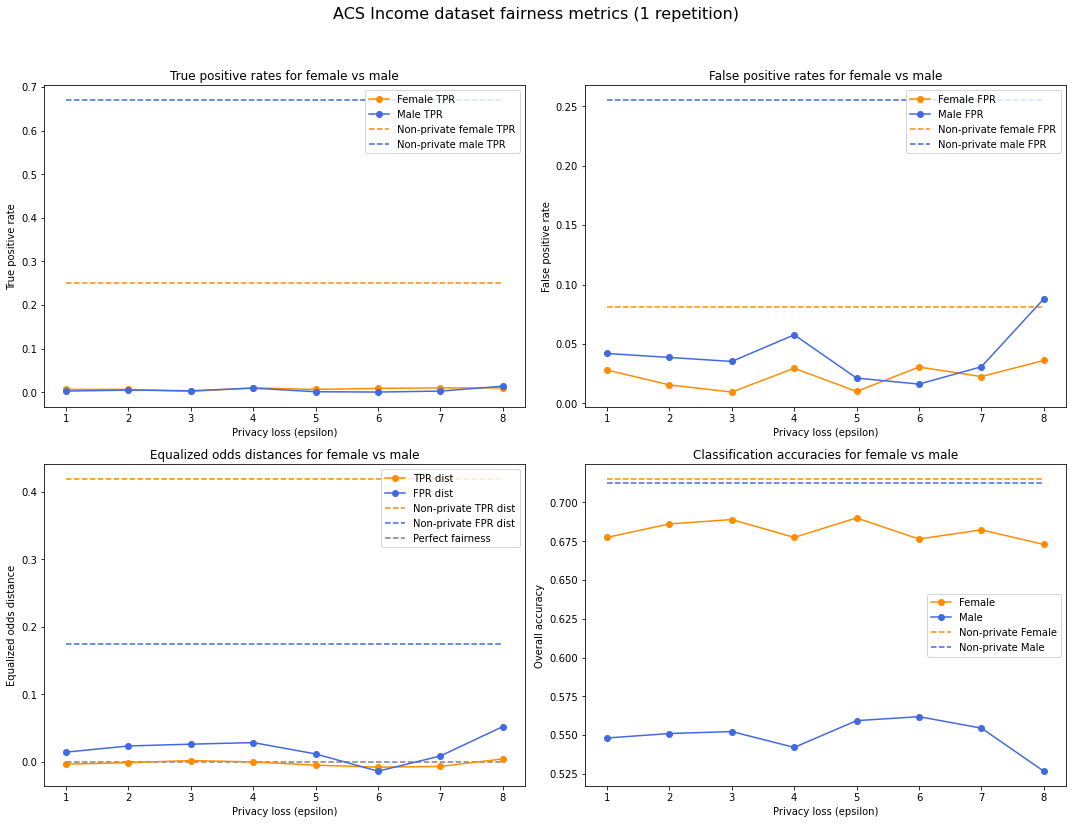

In [25]:
# Plot the fairness and accuracy metrics for 1 repetition
plot_fairness_dict(acs_income_fairness_mwem_1, plot_non_private=True)

In [26]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_mwem_1)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6799
Male Accuracy: 0.5516
Dif in TPR: -0.0028
Dif in FPR: 0.0185


In [63]:
try:
    # Try to load the dictionary with ten repetitions
    acs_income_fairness_mwem_2 = np.load("acs_income_fairness_mwem_2.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    acs_income_fairness_mwem_2 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_mwem_2.npy", acs_income_fairness_mwem_2)

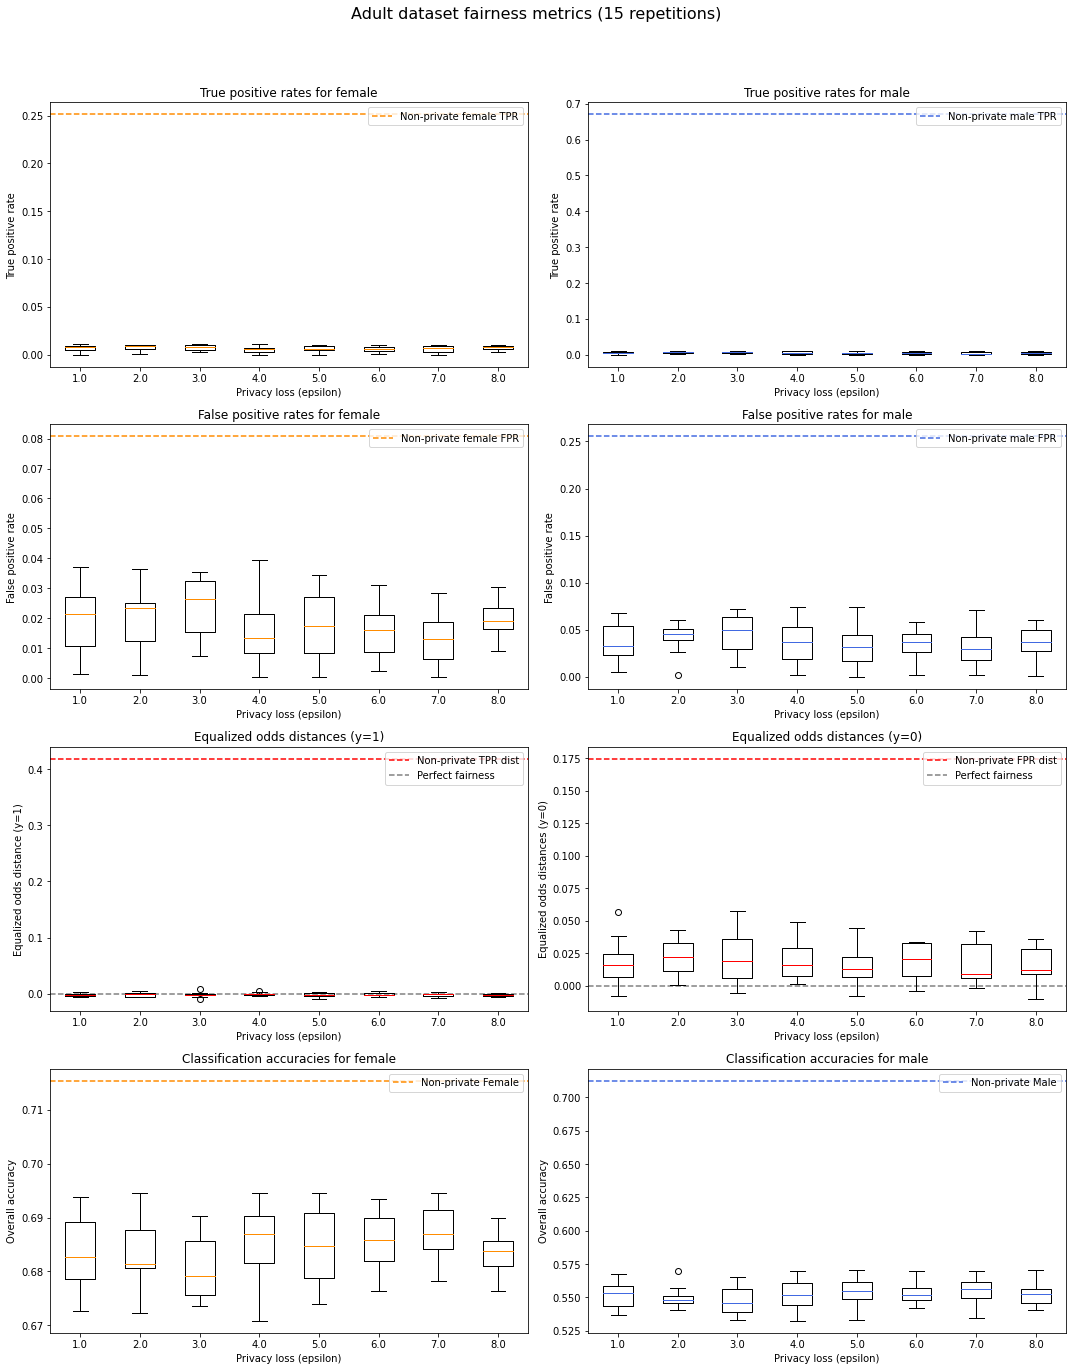

In [64]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_mwem_2, plot_non_private=True)

In [65]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_mwem_2)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6844
Male Accuracy: 0.5519
Dif in TPR: -0.0013
Dif in FPR: 0.016


## 4.3 QUAIL-MWEM

In [69]:
try:
# Try to load the dictionary with ten repetitions
    acs_income_fairness_quail_mwem = np.load("acs_income_fairness_quail_mwem.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

        # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    acs_income_fairness_quail_mwem = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                                            quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)

        # Save dictionary
    np.save("acs_income_fairness_quail_mwem.npy", acs_income_fairness_quail_mwem)

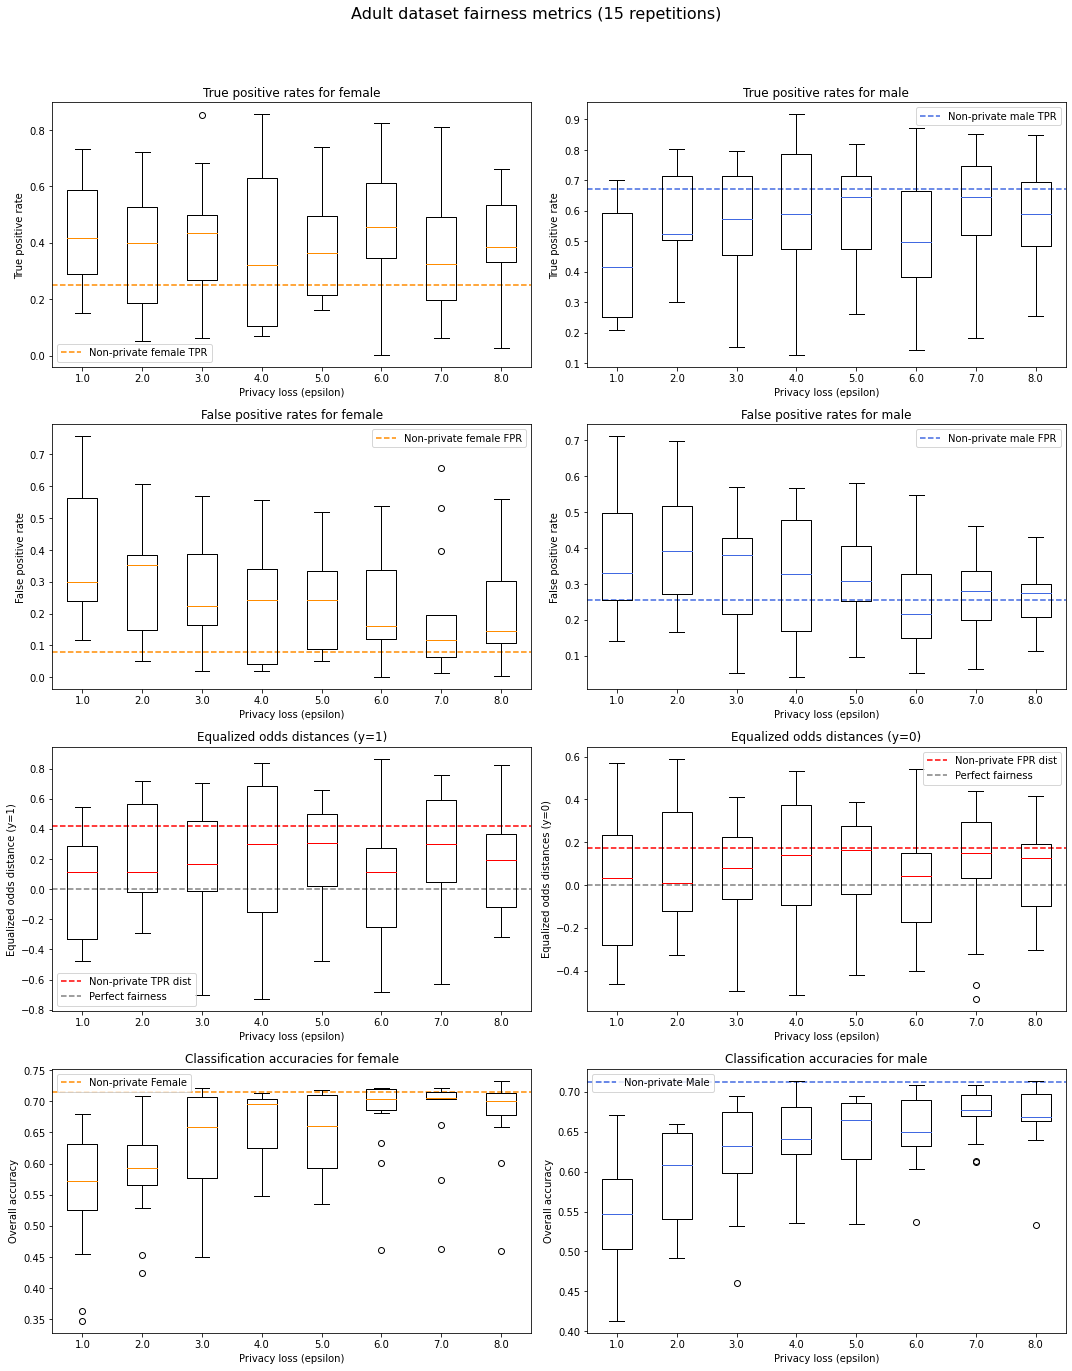

In [70]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_quail_mwem, plot_non_private=True)

In [71]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_quail_mwem)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6804
Male Accuracy: 0.6494
Dif in TPR: 0.1932
Dif in FPR: 0.0911


## 4.4 DPCTGAN

In [22]:
# Start with epsilons 1 and 2
try:
    # Try to load the dictionary with 15 repetitions
    acs_income_fairness_dpctgan_12 = np.load("acs_income_fairness_dpctgan_12.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_dpctgan_12 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", n_reps=10)
    
    # Save dictionary
    np.save("acs_income_fairness_dpctgan_12.npy", acs_income_fairness_dpctgan_12)

In [23]:
# Now do epsilons 3 and 4
try:
    # Try to load the dictionary with 10 repetitions
    acs_income_fairness_dpctgan_34 = np.load("acs_income_fairness_dpctgan_34.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [3.0, 4.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_dpctgan_34 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", n_reps=10)
    
    # Save dictionary
    np.save("acs_income_fairness_dpctgan_34.npy", acs_income_fairness_dpctgan_34)

In [24]:
# Now do epsilons 5 and 6
try:
    # Try to load the dictionary with 10 repetitions
    acs_income_fairness_dpctgan_56 = np.load("acs_income_fairness_dpctgan_56.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [5.0, 6.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_dpctgan_56 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", n_reps=10)
    
    # Save dictionary
    np.save("acs_income_fairness_dpctgan_56.npy", acs_income_fairness_dpctgan_56)

In [ ]:
# Now do epsilon 7
try:
    # Try to load the dictionary with 10 repetitions
    acs_income_fairness_dpctgan_7 = np.load("acs_income_fairness_dpctgan_7.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [7.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_dpctgan_7 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", n_reps=10)
    
    # Save dictionary
    np.save("acs_income_fairness_dpctgan_7.npy", acs_income_fairness_dpctgan_7)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7039, Loss D: 1.4078
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7023, Loss D: 1.4000
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7039, Loss D: 1.3953
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7012, Loss D: 1.3869
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7065, Loss D: 1.3915
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7138, Loss D: 1.3901
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7139, Loss D: 1.3795
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7155, Loss D: 1.3789
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7175, Loss D: 1.3793
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7168, Loss D: 1.3803
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7131, Loss D: 1.3913
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7047, Loss D: 1.4040
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7053, Loss D: 1.3916
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7008, Loss D: 1.3916
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7022, Loss D: 1.3943
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7014, Loss D: 1.3968
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7061, Loss D: 1.3848
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7146, Loss D: 1.3820
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7179, Loss D: 1.3822
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7159, Loss D: 1.3830
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7028, Loss D: 1.3895
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7041, Loss D: 1.3956
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7085, Loss D: 1.3875
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7084, Loss D: 1.3952
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Epoch 1, Loss G: 0.7062, Loss D: 1.3945
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7011, Loss D: 1.3995
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6996, Loss D: 1.3972
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7034, Loss D: 1.3973
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7063, Loss D: 1.3910
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7053, Loss D: 1.3951
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6957, Loss D: 1.3862
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6990, Loss D: 1.3968
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7039, Loss D: 1.3907
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7022, Loss D: 1.3859
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7079, Loss D: 1.3900
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6989, Loss D: 1.3939
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Epoch 1, Loss G: 0.7051, Loss D: 1.4036
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7030, Loss D: 1.4004
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6949, Loss D: 1.4052
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7000, Loss D: 1.3876
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7045, Loss D: 1.3893
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7091, Loss D: 1.3795
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7137, Loss D: 1.3783
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7043, Loss D: 1.3904
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7054, Loss D: 1.3946
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7000, Loss D: 1.3880
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7065, Loss D: 1.3826
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7123, Loss D: 1.3800
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7035, Loss D: 1.3900
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7013, Loss D: 1.3937
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7074, Loss D: 1.4028
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7113, Loss D: 1.3906
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7073, Loss D: 1.3884
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7068, Loss D: 1.3950
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7009, Loss D: 1.3887
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7069, Loss D: 1.3985
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7109, Loss D: 1.3809
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7133, Loss D: 1.3908
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7074, Loss D: 1.3904
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7034, Loss D: 1.3902
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7033, Loss D: 1.3949
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7023, Loss D: 1.3985
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6988, Loss D: 1.4012
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7057, Loss D: 1.3902
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7088, Loss D: 1.3915
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7109, Loss D: 1.3961
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7075, Loss D: 1.3819
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7058, Loss D: 1.3724
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7036, Loss D: 1.3926
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7049, Loss D: 1.3868
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7125, Loss D: 1.3856
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7059, Loss D: 1.3938
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7012, Loss D: 1.3913
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6955, Loss D: 1.3953
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7101, Loss D: 1.3977
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7057, Loss D: 1.3974
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7132, Loss D: 1.3919
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7191, Loss D: 1.3854
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7125, Loss D: 1.3818
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7064, Loss D: 1.3946
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7116, Loss D: 1.3917
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7152, Loss D: 1.3989
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7077, Loss D: 1.3927
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7102, Loss D: 1.4001
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7005, Loss D: 1.3954
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7004, Loss D: 1.4053
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7039, Loss D: 1.3972
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7051, Loss D: 1.3889
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7086, Loss D: 1.3874
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7095, Loss D: 1.3865
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7143, Loss D: 1.3786
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7112, Loss D: 1.3909
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7082, Loss D: 1.3845
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6995, Loss D: 1.3920
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6951, Loss D: 1.3972
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7061, Loss D: 1.3865
epsilon is 0.504

In [ ]:
# And epsilon 8
try:
    # Try to load the dictionary with 10 repetitions
    acs_income_fairness_dpctgan_8 = np.load("acs_income_fairness_dpctgan_8.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [8.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_dpctgan_8 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", n_reps=10)
    
    # Save dictionary
    np.save("acs_income_fairness_dpctgan_8.npy", acs_income_fairness_dpctgan_8)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7102, Loss D: 1.3978
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7015, Loss D: 1.3963
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7029, Loss D: 1.3949
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7084, Loss D: 1.3862
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7092, Loss D: 1.3820
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7061, Loss D: 1.3895
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7147, Loss D: 1.3867
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7168, Loss D: 1.3886
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7089, Loss D: 1.3875
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7150, Loss D: 1.3953
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7144, Loss D: 1.3925
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7152, Loss D: 1.3895
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7033, Loss D: 1.4062
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7006, Loss D: 1.3946
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6972, Loss D: 1.4041
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7001, Loss D: 1.3928
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7043, Loss D: 1.3804
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7012, Loss D: 1.3889
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7053, Loss D: 1.3829
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7057, Loss D: 1.3800
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6884, Loss D: 1.3951
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6908, Loss D: 1.4008
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6943, Loss D: 1.3889
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7088, Loss D: 1.3870
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7125, Loss D: 1.3977
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7069, Loss D: 1.3971
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7014, Loss D: 1.3968
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7049, Loss D: 1.3839
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7113, Loss D: 1.3937
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7115, Loss D: 1.3821
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7142, Loss D: 1.3878
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7087, Loss D: 1.3845
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7132, Loss D: 1.3971
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7051, Loss D: 1.3828
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7115, Loss D: 1.3826
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7131, Loss D: 1.3881
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.6994, Loss D: 1.4007
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7001, Loss D: 1.3961
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7054, Loss D: 1.3974
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7015, Loss D: 1.3888
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7086, Loss D: 1.3776
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7070, Loss D: 1.3898
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7063, Loss D: 1.3844
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7037, Loss D: 1.3958
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7096, Loss D: 1.3831
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7032, Loss D: 1.3861
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7120, Loss D: 1.3820
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7104, Loss D: 1.3974
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Epoch 1, Loss G: 0.7061, Loss D: 1.3975
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7089, Loss D: 1.3953
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7042, Loss D: 1.4018
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6992, Loss D: 1.3943
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7074, Loss D: 1.3979
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7124, Loss D: 1.3918
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7156, Loss D: 1.3911
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7116, Loss D: 1.3851
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7149, Loss D: 1.3905
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7105, Loss D: 1.3802
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7150, Loss D: 1.3869
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7166, Loss D: 1.3840
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.6993, Loss D: 1.3945
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7044, Loss D: 1.3927
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7033, Loss D: 1.3943
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7071, Loss D: 1.3923
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7106, Loss D: 1.3871
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7110, Loss D: 1.3803
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7095, Loss D: 1.3861
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7047, Loss D: 1.3882
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6980, Loss D: 1.3943
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6938, Loss D: 1.4015
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7004, Loss D: 1.3939
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7040, Loss D: 1.3895
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7069, Loss D: 1.3894
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7076, Loss D: 1.3937
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7042, Loss D: 1.3981
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6998, Loss D: 1.3993
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7079, Loss D: 1.3927
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7065, Loss D: 1.3851
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7094, Loss D: 1.3835
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7146, Loss D: 1.3866
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7118, Loss D: 1.3787
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7065, Loss D: 1.3933
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7024, Loss D: 1.3934
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7039, Loss D: 1.3939
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7027, Loss D: 1.3969
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6989, Loss D: 1.3963
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7072, Loss D: 1.3863
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7073, Loss D: 1.3918
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7089, Loss D: 1.3891
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7116, Loss D: 1.3798
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7126, Loss D: 1.3862
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7064, Loss D: 1.3782
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6971, Loss D: 1.4005
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6982, Loss D: 1.4001
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7051, Loss D: 1.3918
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7049, Loss D: 1.3904
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Epoch 1, Loss G: 0.7054, Loss D: 1.4010
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6961, Loss D: 1.3987
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6976, Loss D: 1.4024
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6951, Loss D: 1.4037
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7003, Loss D: 1.3971
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7017, Loss D: 1.3895
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7123, Loss D: 1.3797
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7188, Loss D: 1.3678
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7152, Loss D: 1.3770
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6978, Loss D: 1.3809
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6943, Loss D: 1.3963
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6957, Loss D: 1.3972
epsilon is 0.504

In [27]:
# Combine output
acs_income_fairness_dpctgan_12 = np.load("acs_income_fairness_dpctgan_12.npy", allow_pickle=True).item()
acs_income_fairness_dpctgan_34 = np.load("acs_income_fairness_dpctgan_34.npy", allow_pickle=True).item()
acs_income_fairness_dpctgan_56 = np.load("acs_income_fairness_dpctgan_56.npy", allow_pickle=True).item()
acs_income_fairness_dpctgan_7 = np.load("acs_income_fairness_dpctgan_7.npy", allow_pickle=True).item()
acs_income_fairness_dpctgan_8 = np.load("acs_income_fairness_dpctgan_8.npy", allow_pickle=True).item()


In [28]:
# Join the separate files
acs_income_fairness_dpctgan = {**acs_income_fairness_dpctgan_12, 
                          **acs_income_fairness_dpctgan_34, **acs_income_fairness_dpctgan_56,
                           **acs_income_fairness_dpctgan_7, **acs_income_fairness_dpctgan_8}


In [29]:
# Save combined output
np.save("acs_income_fairness_dpctgan.npy", acs_income_fairness_dpctgan)

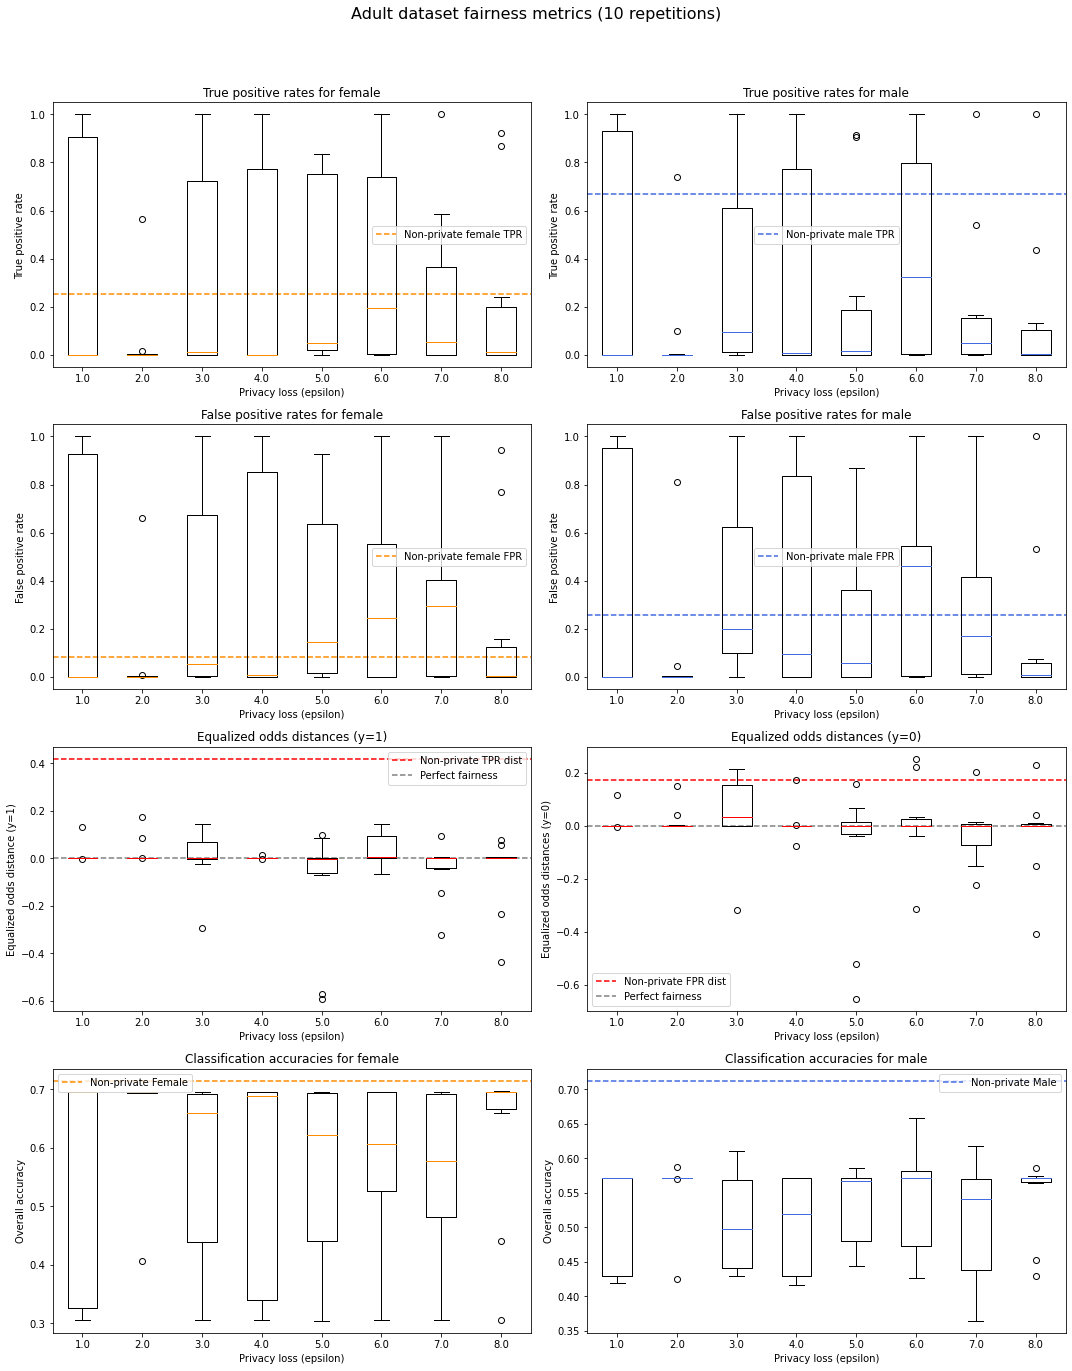

In [30]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_dpctgan, plot_non_private=True)

In [31]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_dpctgan)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6907
Male Accuracy: 0.5705
Dif in TPR: 0.0
Dif in FPR: 0.0


## 4.5 QUAIL-WRAPPED DP-CTGAN

In [ ]:
# First do epsilons 1 and 2
try:
    # Try to load the dictionary
    acs_income_fairness_quail_dpctgan_12 = np.load("acs_income_fairness_quail_dpctgan_12.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_dpctgan_12 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_dpctgan_12.npy", acs_income_fairness_quail_dpctgan_12)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=1.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

In [50]:
# Epsilons 3 and 4
try:
    # Try to load the dictionary
    acs_income_fairness_quail_dpctgan_34 = np.load("acs_income_fairness_quail_dpctgan_34.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [3.0, 4.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_dpctgan_34 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_dpctgan_34.npy", acs_income_fairness_quail_dpctgan_34)
    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7295, Loss D: 1.4283
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7294, Loss D: 1.4198
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7322, Loss D: 1.3893
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7386, Loss D: 1.3862
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6972, Loss D: 1.4255
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6930, Loss D: 1.4283
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7064, Loss D: 1.4092
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7031, Loss D: 1.3985
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7338, Loss D: 1.4287
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7429, Loss D: 1.4179
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7411, Loss D: 1.4024
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7374, Loss D: 1.3979
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6918, Loss D: 1.4308
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6900, Loss D: 1.4218
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7058, Loss D: 1.4068
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6969, Loss D: 1.4079
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7275, Loss D: 1.4051
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7288, Loss D: 1.4156
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7424, Loss D: 1.4092
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7380, Loss D: 1.3915
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6979, Loss D: 1.4214
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6894, Loss D: 1.4206
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6950, Loss D: 1.4092
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7024, Loss D: 1.3958
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7286, Loss D: 1.4199
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7300, Loss D: 1.4100
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7446, Loss D: 1.4071
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7415, Loss D: 1.3977
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6552, Loss D: 1.4320
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6360, Loss D: 1.4205
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6430, Loss D: 1.3934
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6584, Loss D: 1.3931
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6370, Loss D: 1.4333
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6466, Loss D: 1.4140
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6527, Loss D: 1.4077
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6471, Loss D: 1.4117
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7327, Loss D: 1.4210
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7257, Loss D: 1.4269
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7358, Loss D: 1.3977
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7559, Loss D: 1.3898
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6290, Loss D: 1.4373
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6271, Loss D: 1.4311
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6522, Loss D: 1.4181
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6517, Loss D: 1.4059
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6472, Loss D: 1.4350
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6439, Loss D: 1.4316
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6663, Loss D: 1.4056
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6769, Loss D: 1.3778
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7361, Loss D: 1.4196
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7374, Loss D: 1.4159
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7427, Loss D: 1.3944
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7531, Loss D: 1.3880
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6511, Loss D: 1.4353
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6502, Loss D: 1.4261
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6746, Loss D: 1.4137
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6785, Loss D: 1.3797
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6900, Loss D: 1.4281
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6872, Loss D: 1.4142
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6986, Loss D: 1.4034
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6880, Loss D: 1.4188
epsilon is 0.2785953086617374, alpha is 43.0
Completed eps=3.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7350, Loss D: 1.4179
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7220, Loss D: 1.4113
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7291, Loss D: 1.3984
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7355, Loss D: 1.3952
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7362, Loss D: 1.3917
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7331, Loss D: 1.3950
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7239, Loss D: 1.3902
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6996, Loss D: 1.4331
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6899, Loss D: 1.4219
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7010, Loss D: 1.4094
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7062, Loss D: 1.4007
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7033, Loss D: 1.3851
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7108, Loss D: 1.3928
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6843, Loss D: 1.4102
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6355, Loss D: 1.4619
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6465, Loss D: 1.4360
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6545, Loss D: 1.4179
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6648, Loss D: 1.4062
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6491, Loss D: 1.4190
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6632, Loss D: 1.3696
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6762, Loss D: 1.3831
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7270, Loss D: 1.4130
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7232, Loss D: 1.4192
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7430, Loss D: 1.3982
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7448, Loss D: 1.3817
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7480, Loss D: 1.3925
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7376, Loss D: 1.3935
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7358, Loss D: 1.3875
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6450, Loss D: 1.4419
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6365, Loss D: 1.4361
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6485, Loss D: 1.4048
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6517, Loss D: 1.4034
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6720, Loss D: 1.3818
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6502, Loss D: 1.4105
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6235, Loss D: 1.4253
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7222, Loss D: 1.4359
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7241, Loss D: 1.4363
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7425, Loss D: 1.4051
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7382, Loss D: 1.3971
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7407, Loss D: 1.3867
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7429, Loss D: 1.3879
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7433, Loss D: 1.3891
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6786, Loss D: 1.4286
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6916, Loss D: 1.4283
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6998, Loss D: 1.4047
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7011, Loss D: 1.3847
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6888, Loss D: 1.4028
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6923, Loss D: 1.4092
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6977, Loss D: 1.3902
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7253, Loss D: 1.4244
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7390, Loss D: 1.4115
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7486, Loss D: 1.3989
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7471, Loss D: 1.3791
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7361, Loss D: 1.3863
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7344, Loss D: 1.3845
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7273, Loss D: 1.3912
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6456, Loss D: 1.4343
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6560, Loss D: 1.4311
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6700, Loss D: 1.3970
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6708, Loss D: 1.3928
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6615, Loss D: 1.3891
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6532, Loss D: 1.3873
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6607, Loss D: 1.3770
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6845, Loss D: 1.4215
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6890, Loss D: 1.4169
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6896, Loss D: 1.4219
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6997, Loss D: 1.3973
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7030, Loss D: 1.3932
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6972, Loss D: 1.3876
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7060, Loss D: 1.3899
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7328, Loss D: 1.4230
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7236, Loss D: 1.4117
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7308, Loss D: 1.4022
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7356, Loss D: 1.3829
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7377, Loss D: 1.3845
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7315, Loss D: 1.3839
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7359, Loss D: 1.3967
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7277, Loss D: 1.4154
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7274, Loss D: 1.4209
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7316, Loss D: 1.4154
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7313, Loss D: 1.3954
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7367, Loss D: 1.4023
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7316, Loss D: 1.3927
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7254, Loss D: 1.4049
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6244, Loss D: 1.4197
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6171, Loss D: 1.4232
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6317, Loss D: 1.4029
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6319, Loss D: 1.4108
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6342, Loss D: 1.3947
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6294, Loss D: 1.3858
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6449, Loss D: 1.3798
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7026, Loss D: 1.4227
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6805, Loss D: 1.4150
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7022, Loss D: 1.3997
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6973, Loss D: 1.4078
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6833, Loss D: 1.4125
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6863, Loss D: 1.4091
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6729, Loss D: 1.3990
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6291, Loss D: 1.4453
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6350, Loss D: 1.4456
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6364, Loss D: 1.4253
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6557, Loss D: 1.4085
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6670, Loss D: 1.3900
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6557, Loss D: 1.3775
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6662, Loss D: 1.3939
epsilon is 0.37686464613874526, alpha is 33.0
Completed eps=4.0, rep=15.


In [51]:
# Epsilons 5 and 6
try:
    # Try to load the dictionary
    acs_income_fairness_quail_dpctgan_56 = np.load("acs_income_fairness_quail_dpctgan_56.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [5.0, 6.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_dpctgan_56 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_dpctgan_56.npy", acs_income_fairness_quail_dpctgan_56)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6897, Loss D: 1.4197
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6966, Loss D: 1.4153
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7039, Loss D: 1.4136
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6979, Loss D: 1.4115
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6803, Loss D: 1.4096
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6923, Loss D: 1.3983
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7042, Loss D: 1.3937
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6961, Loss D: 1.3936
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6949, Loss D: 1.3991
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6936, Loss D: 1.3951
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7099, Loss D: 1.3879
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6489, Loss D: 1.4317
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6546, Loss D: 1.4193
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6765, Loss D: 1.4054
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6758, Loss D: 1.3866
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6738, Loss D: 1.3867
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6465, Loss D: 1.3901
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6445, Loss D: 1.4133
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6344, Loss D: 1.4063
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6399, Loss D: 1.4079
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6340, Loss D: 1.4030
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6483, Loss D: 1.4224
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6869, Loss D: 1.4193
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6973, Loss D: 1.4104
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7076, Loss D: 1.3979
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6955, Loss D: 1.3818
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6972, Loss D: 1.3904
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6975, Loss D: 1.3827
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6797, Loss D: 1.3801
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6810, Loss D: 1.3896
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6864, Loss D: 1.4020
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6793, Loss D: 1.3872
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6874, Loss D: 1.3836
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6940, Loss D: 1.4286
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6898, Loss D: 1.4224
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7019, Loss D: 1.4097
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7043, Loss D: 1.3952
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6936, Loss D: 1.4161
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7027, Loss D: 1.4007
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6997, Loss D: 1.4111
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6956, Loss D: 1.4079
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7032, Loss D: 1.4044
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7175, Loss D: 1.3911
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7006, Loss D: 1.3968
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6518, Loss D: 1.4203
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6522, Loss D: 1.4467
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6679, Loss D: 1.4129
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6749, Loss D: 1.3916
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6866, Loss D: 1.3716
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6717, Loss D: 1.3841
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6886, Loss D: 1.3711
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6767, Loss D: 1.3843
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6415, Loss D: 1.3875
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6381, Loss D: 1.4085
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6164, Loss D: 1.4274
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6406, Loss D: 1.4470
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6475, Loss D: 1.4300
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6494, Loss D: 1.4062
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6559, Loss D: 1.4010
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6613, Loss D: 1.3922
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6661, Loss D: 1.3670
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6376, Loss D: 1.4167
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6369, Loss D: 1.4284
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6149, Loss D: 1.4318
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6228, Loss D: 1.4374
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6160, Loss D: 1.4305
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6966, Loss D: 1.4186
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6909, Loss D: 1.4184
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6979, Loss D: 1.4061
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7050, Loss D: 1.4050
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6895, Loss D: 1.4038
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7081, Loss D: 1.3795
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6895, Loss D: 1.3817
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6791, Loss D: 1.3950
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6972, Loss D: 1.3934
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6967, Loss D: 1.3923
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6736, Loss D: 1.4031
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6506, Loss D: 1.4315
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6405, Loss D: 1.4286
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6707, Loss D: 1.4043
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6497, Loss D: 1.4122
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6464, Loss D: 1.3962
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6392, Loss D: 1.4109
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6598, Loss D: 1.3799
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6588, Loss D: 1.3884
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6388, Loss D: 1.3899
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6389, Loss D: 1.3852
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6403, Loss D: 1.3951
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6370, Loss D: 1.4425
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6464, Loss D: 1.4485
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6642, Loss D: 1.4253
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6464, Loss D: 1.4220
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6687, Loss D: 1.4068
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6757, Loss D: 1.3903
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6462, Loss D: 1.4044
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6384, Loss D: 1.4244
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6448, Loss D: 1.4148
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6304, Loss D: 1.3960
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6510, Loss D: 1.3929
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6929, Loss D: 1.4249
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6895, Loss D: 1.4038
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7005, Loss D: 1.3976
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6960, Loss D: 1.4013
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6974, Loss D: 1.3863
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6911, Loss D: 1.4007
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6769, Loss D: 1.3974
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6717, Loss D: 1.4190
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6807, Loss D: 1.3980
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6848, Loss D: 1.4037
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6855, Loss D: 1.3981
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Epoch 1, Loss G: 0.6500, Loss D: 1.4326
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6479, Loss D: 1.4297
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6604, Loss D: 1.4112
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6765, Loss D: 1.4061
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6602, Loss D: 1.4064
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6617, Loss D: 1.3945
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6674, Loss D: 1.3973
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6336, Loss D: 1.4200
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6295, Loss D: 1.4166
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6281, Loss D: 1.4281
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6600, Loss D: 1.4152
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7304, Loss D: 1.4253
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7323, Loss D: 1.4236
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7402, Loss D: 1.4090
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7525, Loss D: 1.3854
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7552, Loss D: 1.3756
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7387, Loss D: 1.3889
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7273, Loss D: 1.4024
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7310, Loss D: 1.3938
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7373, Loss D: 1.3924
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7377, Loss D: 1.3975
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7467, Loss D: 1.4068
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6223, Loss D: 1.4405
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6397, Loss D: 1.4139
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6443, Loss D: 1.4063
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6549, Loss D: 1.4092
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6353, Loss D: 1.4212
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6413, Loss D: 1.4127
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6352, Loss D: 1.4127
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6406, Loss D: 1.3852
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6513, Loss D: 1.4014
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6356, Loss D: 1.3952
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6444, Loss D: 1.3878
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6887, Loss D: 1.4240
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6840, Loss D: 1.4236
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7074, Loss D: 1.4050
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7105, Loss D: 1.3911
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6969, Loss D: 1.4241
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6977, Loss D: 1.3948
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7001, Loss D: 1.4046
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7092, Loss D: 1.3864
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7179, Loss D: 1.3817
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7116, Loss D: 1.3945
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7173, Loss D: 1.3859
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6362, Loss D: 1.4358
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6403, Loss D: 1.4224
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6377, Loss D: 1.4235
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6559, Loss D: 1.4063
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6357, Loss D: 1.3895
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6268, Loss D: 1.4118
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6411, Loss D: 1.3928
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6749, Loss D: 1.3732
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6811, Loss D: 1.3756
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6595, Loss D: 1.3930
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6351, Loss D: 1.3849
epsilon is 0.4814046197432539, alpha is 27.0
Completed eps=5.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7308, Loss D: 1.4153
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7190, Loss D: 1.4267
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7429, Loss D: 1.4180
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7442, Loss D: 1.4032
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7447, Loss D: 1.3798
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7439, Loss D: 1.3908
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7266, Loss D: 1.3779
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7286, Loss D: 1.3896
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7321, Loss D: 1.4015
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7321, Loss D: 1.3903
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7298, Loss D: 1.3921
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7459, Loss D: 1.3943
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6869, Loss D: 1.4313
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6805, Loss D: 1.4314
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6823, Loss D: 1.4001
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7009, Loss D: 1.3852
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6929, Loss D: 1.4063
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6821, Loss D: 1.4147
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6818, Loss D: 1.3977
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6881, Loss D: 1.3863
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6881, Loss D: 1.4093
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6758, Loss D: 1.3895
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6838, Loss D: 1.4001
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6754, Loss D: 1.3984
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6413, Loss D: 1.4349
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6411, Loss D: 1.4197
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6703, Loss D: 1.4038
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6447, Loss D: 1.4131
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6514, Loss D: 1.4048
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6628, Loss D: 1.3871
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6887, Loss D: 1.3823
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6808, Loss D: 1.3736
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6636, Loss D: 1.3894
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6348, Loss D: 1.4193
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6372, Loss D: 1.4005
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6534, Loss D: 1.4044
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6393, Loss D: 1.4014
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6263, Loss D: 1.3977
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6356, Loss D: 1.4108
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6234, Loss D: 1.4107
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6197, Loss D: 1.4144
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6282, Loss D: 1.3830
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6189, Loss D: 1.3874
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6234, Loss D: 1.3851
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6073, Loss D: 1.4219
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6164, Loss D: 1.4140
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6141, Loss D: 1.4123
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6109, Loss D: 1.4098
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7305, Loss D: 1.4088
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7258, Loss D: 1.4142
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7293, Loss D: 1.4013
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7358, Loss D: 1.3961
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7467, Loss D: 1.3827
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7305, Loss D: 1.3918
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7316, Loss D: 1.4105
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7325, Loss D: 1.3966
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7261, Loss D: 1.4106
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7320, Loss D: 1.3923
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7309, Loss D: 1.3883
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7354, Loss D: 1.4004
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6995, Loss D: 1.4313
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6889, Loss D: 1.4379
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7013, Loss D: 1.4149
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6966, Loss D: 1.3774
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7016, Loss D: 1.3820
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6822, Loss D: 1.3995
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6715, Loss D: 1.4139
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6970, Loss D: 1.4023
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7034, Loss D: 1.3789
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6921, Loss D: 1.3929
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7022, Loss D: 1.3607
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7004, Loss D: 1.3901
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6957, Loss D: 1.4252
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6832, Loss D: 1.4285
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6946, Loss D: 1.4068
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6998, Loss D: 1.3964
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7020, Loss D: 1.3878
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6886, Loss D: 1.4010
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6820, Loss D: 1.4070
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6865, Loss D: 1.4046
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6927, Loss D: 1.3968
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7031, Loss D: 1.3819
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6754, Loss D: 1.4040
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6814, Loss D: 1.3941
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6883, Loss D: 1.4178
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7017, Loss D: 1.4266
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7063, Loss D: 1.4009
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7069, Loss D: 1.3955
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7042, Loss D: 1.3961
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6987, Loss D: 1.3835
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6818, Loss D: 1.3976
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6941, Loss D: 1.4040
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7019, Loss D: 1.3754
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6980, Loss D: 1.3883
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7052, Loss D: 1.3955
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6912, Loss D: 1.3943
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6491, Loss D: 1.4296
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6351, Loss D: 1.4192
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6646, Loss D: 1.4029
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6665, Loss D: 1.3841
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6379, Loss D: 1.4090
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6586, Loss D: 1.3908
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6546, Loss D: 1.4023
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6313, Loss D: 1.4040
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6287, Loss D: 1.4136
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6304, Loss D: 1.3902
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6498, Loss D: 1.3743
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6277, Loss D: 1.4041
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6496, Loss D: 1.4336
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6401, Loss D: 1.4318
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6426, Loss D: 1.4145
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6513, Loss D: 1.4085
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6613, Loss D: 1.3951
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6631, Loss D: 1.3814
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6409, Loss D: 1.4049
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6149, Loss D: 1.4188
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6355, Loss D: 1.4153
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6444, Loss D: 1.3825
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6356, Loss D: 1.4000
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6338, Loss D: 1.3705
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7232, Loss D: 1.4169
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7256, Loss D: 1.4142
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7377, Loss D: 1.3990
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7332, Loss D: 1.3995
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7308, Loss D: 1.3990
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7281, Loss D: 1.4022
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7011, Loss D: 1.4125
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7084, Loss D: 1.4042
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7320, Loss D: 1.3973
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7302, Loss D: 1.3930
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7268, Loss D: 1.4057
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7297, Loss D: 1.3911
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6509, Loss D: 1.4268
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6433, Loss D: 1.4244
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6644, Loss D: 1.4135
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6709, Loss D: 1.3911
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6743, Loss D: 1.3749
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6536, Loss D: 1.4058
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6476, Loss D: 1.3965
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6451, Loss D: 1.3939
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6358, Loss D: 1.4103
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6282, Loss D: 1.4170
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6375, Loss D: 1.4072
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6649, Loss D: 1.3822
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6372, Loss D: 1.4421
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6376, Loss D: 1.4270
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6571, Loss D: 1.4095
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6473, Loss D: 1.3911
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6663, Loss D: 1.3964
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6483, Loss D: 1.4054
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6394, Loss D: 1.4087
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6284, Loss D: 1.4150
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6379, Loss D: 1.4215
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6252, Loss D: 1.4161
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6251, Loss D: 1.4108
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6434, Loss D: 1.3837
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7284, Loss D: 1.4297
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7169, Loss D: 1.4285
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7401, Loss D: 1.4034
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7364, Loss D: 1.3899
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7514, Loss D: 1.3723
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7463, Loss D: 1.3830
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7286, Loss D: 1.3891
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7206, Loss D: 1.3956
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7306, Loss D: 1.3996
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7412, Loss D: 1.3929
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7466, Loss D: 1.4113
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7560, Loss D: 1.3899
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7249, Loss D: 1.4318
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7278, Loss D: 1.4193
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7382, Loss D: 1.4001
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7378, Loss D: 1.3931
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7418, Loss D: 1.3945
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7238, Loss D: 1.4107
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7191, Loss D: 1.4034
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7160, Loss D: 1.4073
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7234, Loss D: 1.3969
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7213, Loss D: 1.3879
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7284, Loss D: 1.3934
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7310, Loss D: 1.3822
epsilon is 0.504

In [52]:
# Epsilons 7 and 8
try:
    # Try to load the dictionary
    acs_income_fairness_quail_dpctgan_78 = np.load("acs_income_fairness_quail_dpctgan_78.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_dpctgan_78 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_dpctgan_78.npy", acs_income_fairness_quail_dpctgan_78)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7339, Loss D: 1.4084
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7300, Loss D: 1.4050
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7394, Loss D: 1.4000
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7388, Loss D: 1.3991
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7407, Loss D: 1.3932
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7300, Loss D: 1.3974
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7383, Loss D: 1.3992
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7386, Loss D: 1.4037
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7408, Loss D: 1.3926
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7497, Loss D: 1.3910
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7382, Loss D: 1.3844
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7516, Loss D: 1.3856
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6472, Loss D: 1.4388
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6446, Loss D: 1.4224
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6685, Loss D: 1.3989
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6773, Loss D: 1.3789
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6652, Loss D: 1.3772
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6450, Loss D: 1.4059
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6543, Loss D: 1.3894
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6310, Loss D: 1.3984
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6405, Loss D: 1.4102
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6248, Loss D: 1.4023
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6142, Loss D: 1.4246
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6143, Loss D: 1.4201
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6460, Loss D: 1.4308
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6431, Loss D: 1.4326
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6572, Loss D: 1.4124
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6660, Loss D: 1.3909
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6680, Loss D: 1.3796
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6710, Loss D: 1.3910
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6597, Loss D: 1.3865
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6310, Loss D: 1.4076
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6204, Loss D: 1.4229
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6228, Loss D: 1.4043
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6213, Loss D: 1.4030
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6386, Loss D: 1.4153
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7337, Loss D: 1.4242
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7317, Loss D: 1.4222
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7393, Loss D: 1.4009
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7453, Loss D: 1.3952
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7489, Loss D: 1.3952
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7521, Loss D: 1.3986
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7448, Loss D: 1.3879
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7208, Loss D: 1.4025
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7304, Loss D: 1.3971
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7352, Loss D: 1.3999
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7410, Loss D: 1.3936
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7360, Loss D: 1.3968
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7229, Loss D: 1.4255
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7293, Loss D: 1.4193
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7509, Loss D: 1.3908
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7480, Loss D: 1.4029
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7520, Loss D: 1.3798
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7443, Loss D: 1.3755
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7353, Loss D: 1.3913
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7157, Loss D: 1.4007
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7209, Loss D: 1.4163
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7189, Loss D: 1.3936
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7225, Loss D: 1.3956
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7212, Loss D: 1.3950
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6381, Loss D: 1.4449
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6431, Loss D: 1.4225
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6594, Loss D: 1.4180
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6705, Loss D: 1.3952
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6677, Loss D: 1.3878
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6682, Loss D: 1.3790
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6629, Loss D: 1.3825
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6519, Loss D: 1.3957
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6398, Loss D: 1.4094
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6502, Loss D: 1.3969
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6301, Loss D: 1.3988
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6444, Loss D: 1.3910
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6495, Loss D: 1.4362
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6394, Loss D: 1.4320
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6592, Loss D: 1.4001
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6525, Loss D: 1.3939
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6526, Loss D: 1.4187
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6538, Loss D: 1.4025
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6693, Loss D: 1.3753
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6749, Loss D: 1.3716
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6326, Loss D: 1.4035
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6163, Loss D: 1.4157
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6149, Loss D: 1.4339
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6120, Loss D: 1.4147
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7349, Loss D: 1.4304
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7282, Loss D: 1.4229
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7460, Loss D: 1.3993
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7433, Loss D: 1.3868
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7459, Loss D: 1.3749
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7407, Loss D: 1.3822
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7167, Loss D: 1.3976
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7141, Loss D: 1.4018
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7166, Loss D: 1.3942
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7126, Loss D: 1.4052
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7119, Loss D: 1.3959
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7289, Loss D: 1.3878
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7382, Loss D: 1.4162
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7209, Loss D: 1.4283
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7357, Loss D: 1.4134
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7451, Loss D: 1.4099
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7426, Loss D: 1.4003
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7450, Loss D: 1.3726
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7430, Loss D: 1.3847
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7510, Loss D: 1.3915
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7279, Loss D: 1.3943
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7255, Loss D: 1.3967
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7375, Loss D: 1.4019
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7347, Loss D: 1.4156
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Epoch 1, Loss G: 0.7327, Loss D: 1.4184
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7264, Loss D: 1.4121
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7273, Loss D: 1.4193
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7402, Loss D: 1.4002
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7469, Loss D: 1.3989
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7462, Loss D: 1.3855
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7322, Loss D: 1.4082
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7382, Loss D: 1.3944
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7369, Loss D: 1.3892
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7405, Loss D: 1.3885
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7388, Loss D: 1.3975
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7415, Loss D: 1.3826
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6426, Loss D: 1.4345
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6406, Loss D: 1.4292
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6592, Loss D: 1.3982
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6738, Loss D: 1.3907
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6638, Loss D: 1.3893
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6365, Loss D: 1.3916
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6346, Loss D: 1.4046
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6416, Loss D: 1.4070
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6161, Loss D: 1.4223
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6260, Loss D: 1.4145
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6418, Loss D: 1.3916
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6441, Loss D: 1.3955
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6894, Loss D: 1.4193
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6853, Loss D: 1.4315
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7069, Loss D: 1.4154
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7086, Loss D: 1.3939
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7191, Loss D: 1.3847
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7117, Loss D: 1.3907
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6821, Loss D: 1.4104
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6681, Loss D: 1.4203
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6714, Loss D: 1.4079
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6899, Loss D: 1.4054
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6961, Loss D: 1.3890
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6829, Loss D: 1.3826
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6357, Loss D: 1.4455
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6353, Loss D: 1.4255
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6568, Loss D: 1.4064
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6574, Loss D: 1.4040
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6456, Loss D: 1.3989
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6548, Loss D: 1.3960
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6336, Loss D: 1.4186
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6377, Loss D: 1.3885
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6567, Loss D: 1.3962
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6413, Loss D: 1.3867
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6549, Loss D: 1.3823
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6536, Loss D: 1.3691
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6455, Loss D: 1.4209
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6453, Loss D: 1.4233
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6578, Loss D: 1.3973
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6661, Loss D: 1.3828
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6572, Loss D: 1.3847
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6624, Loss D: 1.3789
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6360, Loss D: 1.4104
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6402, Loss D: 1.4133
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6204, Loss D: 1.4155
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6022, Loss D: 1.4520
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6159, Loss D: 1.4389
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6408, Loss D: 1.3961
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7234, Loss D: 1.4309
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7377, Loss D: 1.4155
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7426, Loss D: 1.3867
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7507, Loss D: 1.3865
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7374, Loss D: 1.3853
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7326, Loss D: 1.3907
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7377, Loss D: 1.3850
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7247, Loss D: 1.4021
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7447, Loss D: 1.4099
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7420, Loss D: 1.3939
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7349, Loss D: 1.3985
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7471, Loss D: 1.3788
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6491, Loss D: 1.4354
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6511, Loss D: 1.4234
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6682, Loss D: 1.4101
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6704, Loss D: 1.4144
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6545, Loss D: 1.3994
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6620, Loss D: 1.3787
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6491, Loss D: 1.3931
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6531, Loss D: 1.3895
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6336, Loss D: 1.3768
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6372, Loss D: 1.4085
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6258, Loss D: 1.4109
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6351, Loss D: 1.4015
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Epoch 1, Loss G: 0.7361, Loss D: 1.4200
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7304, Loss D: 1.4126
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7398, Loss D: 1.4145
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7565, Loss D: 1.3903
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7463, Loss D: 1.3975
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7362, Loss D: 1.3937
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7294, Loss D: 1.4040
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7454, Loss D: 1.3967
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7446, Loss D: 1.3980
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7432, Loss D: 1.4061
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7400, Loss D: 1.3964
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7388, Loss D: 1.3939
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6666, Loss D: 1.4504
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6505, Loss D: 1.4188
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6589, Loss D: 1.4086
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6616, Loss D: 1.4074
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6701, Loss D: 1.3932
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6569, Loss D: 1.3934
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6520, Loss D: 1.3882
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6455, Loss D: 1.4002
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6341, Loss D: 1.4129
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6266, Loss D: 1.4188
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6353, Loss D: 1.4141
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6274, Loss D: 1.4017
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6298, Loss D: 1.4099
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6223, Loss D: 1.4287
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6260, Loss D: 1.4049
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6373, Loss D: 1.3938
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6390, Loss D: 1.3833
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6252, Loss D: 1.3930
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6140, Loss D: 1.4032
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6092, Loss D: 1.3986
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6000, Loss D: 1.4111
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6086, Loss D: 1.4172
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6177, Loss D: 1.3877
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6163, Loss D: 1.4186
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7001, Loss D: 1.4134
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6932, Loss D: 1.4210
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6968, Loss D: 1.4170
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7075, Loss D: 1.3907
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6937, Loss D: 1.4015
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6928, Loss D: 1.4104
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6843, Loss D: 1.4069
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6890, Loss D: 1.3918
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6937, Loss D: 1.3918
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7009, Loss D: 1.3897
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6805, Loss D: 1.4029
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6831, Loss D: 1.3950
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6950, Loss D: 1.4272
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6891, Loss D: 1.4135
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7003, Loss D: 1.4099
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7029, Loss D: 1.3982
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7086, Loss D: 1.3866
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6876, Loss D: 1.3872
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6921, Loss D: 1.3621
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6737, Loss D: 1.4035
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6688, Loss D: 1.3964
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6875, Loss D: 1.4140
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6833, Loss D: 1.4088
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6595, Loss D: 1.4108
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7029, Loss D: 1.4134
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6933, Loss D: 1.4242
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6964, Loss D: 1.3816
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6944, Loss D: 1.4083
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6940, Loss D: 1.4058
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6967, Loss D: 1.3845
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6778, Loss D: 1.3975
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6881, Loss D: 1.3864
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6805, Loss D: 1.3894
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7090, Loss D: 1.3731
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7050, Loss D: 1.3948
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6860, Loss D: 1.3912
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6999, Loss D: 1.4238
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6975, Loss D: 1.4144
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7013, Loss D: 1.4117
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7107, Loss D: 1.4003
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7192, Loss D: 1.3766
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6989, Loss D: 1.4108
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6885, Loss D: 1.3982
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7003, Loss D: 1.3841
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6948, Loss D: 1.3800
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6752, Loss D: 1.3780
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6700, Loss D: 1.4108
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6995, Loss D: 1.3823
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6836, Loss D: 1.4341
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6931, Loss D: 1.4403
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7016, Loss D: 1.3990
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6982, Loss D: 1.3898
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7010, Loss D: 1.3874
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7018, Loss D: 1.3712
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6819, Loss D: 1.3928
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6874, Loss D: 1.4063
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6954, Loss D: 1.3828
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7101, Loss D: 1.3644
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6871, Loss D: 1.3707
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6788, Loss D: 1.3873
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6267, Loss D: 1.4265
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6372, Loss D: 1.4229
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6245, Loss D: 1.4287
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6235, Loss D: 1.4000
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6286, Loss D: 1.4056
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6279, Loss D: 1.4099
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6374, Loss D: 1.3866
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6261, Loss D: 1.3805
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6269, Loss D: 1.3873
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6317, Loss D: 1.4009
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6135, Loss D: 1.4119
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6243, Loss D: 1.4046
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7278, Loss D: 1.4191
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.7249, Loss D: 1.4079
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7348, Loss D: 1.4180
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7479, Loss D: 1.3911
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7535, Loss D: 1.3848
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.7344, Loss D: 1.3928
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.7262, Loss D: 1.3925
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.7223, Loss D: 1.4136
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7219, Loss D: 1.4060
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7217, Loss D: 1.4092
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.7284, Loss D: 1.4131
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7325, Loss D: 1.4018
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6552, Loss D: 1.4323
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6483, Loss D: 1.4274
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6648, Loss D: 1.4120
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6653, Loss D: 1.3791
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6647, Loss D: 1.3737
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6656, Loss D: 1.3919
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6544, Loss D: 1.4066
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6561, Loss D: 1.3893
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6423, Loss D: 1.3971
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6403, Loss D: 1.4200
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6392, Loss D: 1.4093
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6523, Loss D: 1.3981
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.7060, Loss D: 1.4112
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6747, Loss D: 1.4123
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6903, Loss D: 1.4003
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7048, Loss D: 1.3875
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6869, Loss D: 1.4126
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6880, Loss D: 1.3965
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6873, Loss D: 1.4035
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6929, Loss D: 1.3953
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6947, Loss D: 1.3948
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7026, Loss D: 1.4039
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6844, Loss D: 1.3997
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.7033, Loss D: 1.3897
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6945, Loss D: 1.4333
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6881, Loss D: 1.4259
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.7107, Loss D: 1.4230
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.7067, Loss D: 1.4009
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.7138, Loss D: 1.3897
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6755, Loss D: 1.3919
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6760, Loss D: 1.4168
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6886, Loss D: 1.4024
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.7068, Loss D: 1.3827
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.7004, Loss D: 1.3808
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6965, Loss D: 1.3772
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6959, Loss D: 1.3803
epsilon is 0.504

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Epoch 1, Loss G: 0.6542, Loss D: 1.4239
epsilon is 0.13637430555636942, alpha is 63.0
Epoch 2, Loss G: 0.6609, Loss D: 1.4209
epsilon is 0.19191638538486006, alpha is 58.0
Epoch 3, Loss G: 0.6659, Loss D: 1.4209
epsilon is 0.23861451973372627, alpha is 48.0
Epoch 4, Loss G: 0.6665, Loss D: 1.3976
epsilon is 0.2785953086617374, alpha is 43.0
Epoch 5, Loss G: 0.6604, Loss D: 1.3905
epsilon is 0.3142224409031283, alpha is 39.0
Epoch 6, Loss G: 0.6688, Loss D: 1.3906
epsilon is 0.3467316827266135, alpha is 36.0
Epoch 7, Loss G: 0.6811, Loss D: 1.3622
epsilon is 0.37686464613874526, alpha is 33.0
Epoch 8, Loss G: 0.6786, Loss D: 1.3858
epsilon is 0.40512228648630166, alpha is 31.0
Epoch 9, Loss G: 0.6347, Loss D: 1.4124
epsilon is 0.4317579428671998, alpha is 30.0
Epoch 10, Loss G: 0.6149, Loss D: 1.4271
epsilon is 0.45720368497085706, alpha is 28.0
Epoch 11, Loss G: 0.6310, Loss D: 1.4075
epsilon is 0.4814046197432539, alpha is 27.0
Epoch 12, Loss G: 0.6342, Loss D: 1.4154
epsilon is 0.504

In [53]:
# Combine output
acs_income_fairness_quail_dpctgan_12 = np.load("acs_income_fairness_quail_dpctgan_12.npy", allow_pickle=True).item()
acs_income_fairness_quail_dpctgan_34 = np.load("acs_income_fairness_quail_dpctgan_34.npy", allow_pickle=True).item()
acs_income_fairness_quail_dpctgan_56 = np.load("acs_income_fairness_quail_dpctgan_56.npy", allow_pickle=True).item()
acs_income_fairness_quail_dpctgan_78 = np.load("acs_income_fairness_quail_dpctgan_78.npy", allow_pickle=True).item()


In [54]:
# Join the separate files
acs_income_fairness_quail_dpctgan = {**acs_income_fairness_quail_dpctgan_12, 
                                     **acs_income_fairness_quail_dpctgan_34,
                                     **acs_income_fairness_quail_dpctgan_56,
                                     **acs_income_fairness_quail_dpctgan_78}


In [55]:
# Save combined output
np.save("acs_income_fairness_quail_dpctgan.npy", acs_income_fairness_quail_dpctgan)

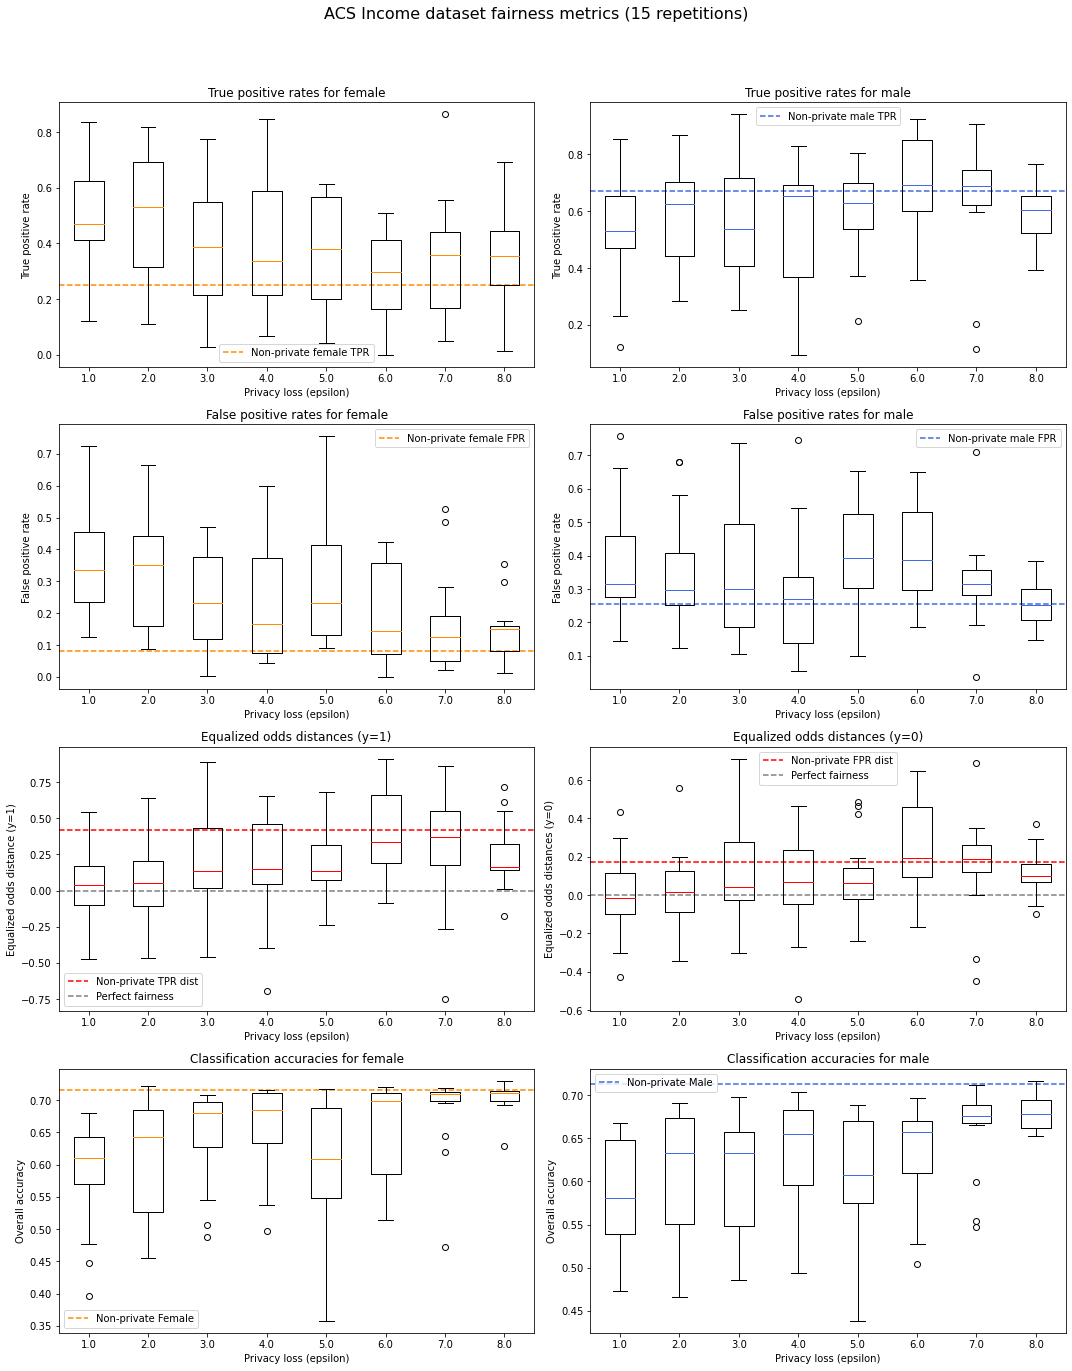

In [59]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_quail_dpctgan, plot_non_private=True)

In [57]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_quail_dpctgan)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6782
Male Accuracy: 0.6544
Dif in TPR: 0.1588
Dif in FPR: 0.0866


## 4.6 PATE-CTGAN

In [35]:
# test

try:
    # Try to load the dictionary
    acs_income_fairness_patectgan_test = np.load("acs_income_fairness_patectgan_test.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_patectgan_test = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=False, classifier="DPLR", eps_split=0.8, n_reps=1)
    
    # Save dictionary
    np.save("acs_income_fairness_patectgan_test.npy", acs_income_fairness_patectgan_test)

In [37]:
# First do epsilons 1 and 2

try:
    # Try to load the dictionary
    acs_income_fairness_patectgan_12 = np.load("acs_income_fairness_patectgan_12.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_patectgan_12 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=False, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_patectgan_12.npy", acs_income_fairness_patectgan_12)

In [40]:
# Epsilons 3 and 4

try:
    # Try to load the dictionary
    acs_income_fairness_patectgan_34 = np.load("acs_income_fairness_patectgan_34.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [3.0, 4.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_patectgan_34 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=False, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_patectgan_34.npy", acs_income_fairness_patectgan_34)

In [46]:
# Epsilons 5 and 6

try:
    # Try to load the dictionary
    acs_income_fairness_patectgan_56 = np.load("acs_income_fairness_patectgan_56.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [5.0, 6.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_patectgan_56 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=False, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_patectgan_56.npy", acs_income_fairness_patectgan_56)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=5.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=5.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=5.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=5.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=5.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=5.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=6.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=6.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=6.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=6.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=6.0, rep=15.


In [ ]:
# Epsilons 7 and 8

try:
    # Try to load the dictionary
    acs_income_fairness_patectgan_78 = np.load("acs_income_fairness_patectgan_78.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_patectgan_78 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=False, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_patectgan_78.npy", acs_income_fairness_patectgan_78)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=7.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=7.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=7.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword ar

Completed eps=8.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

Completed eps=8.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clust

In [32]:
# Combine output
acs_income_fairness_patectgan_12 = np.load("acs_income_fairness_patectgan_12.npy", allow_pickle=True).item()
acs_income_fairness_patectgan_34 = np.load("acs_income_fairness_patectgan_34.npy", allow_pickle=True).item()
acs_income_fairness_patectgan_56 = np.load("acs_income_fairness_patectgan_56.npy", allow_pickle=True).item()
acs_income_fairness_patectgan_78 = np.load("acs_income_fairness_patectgan_78.npy", allow_pickle=True).item()


In [33]:
# Join the separate files
acs_income_fairness_patectgan = {**acs_income_fairness_patectgan_12, 
                                     **acs_income_fairness_patectgan_34,
                                     **acs_income_fairness_patectgan_56,
                                     **acs_income_fairness_patectgan_78}


In [34]:
# Save combined output
np.save("acs_income_fairness_patectgan.npy", acs_income_fairness_patectgan)

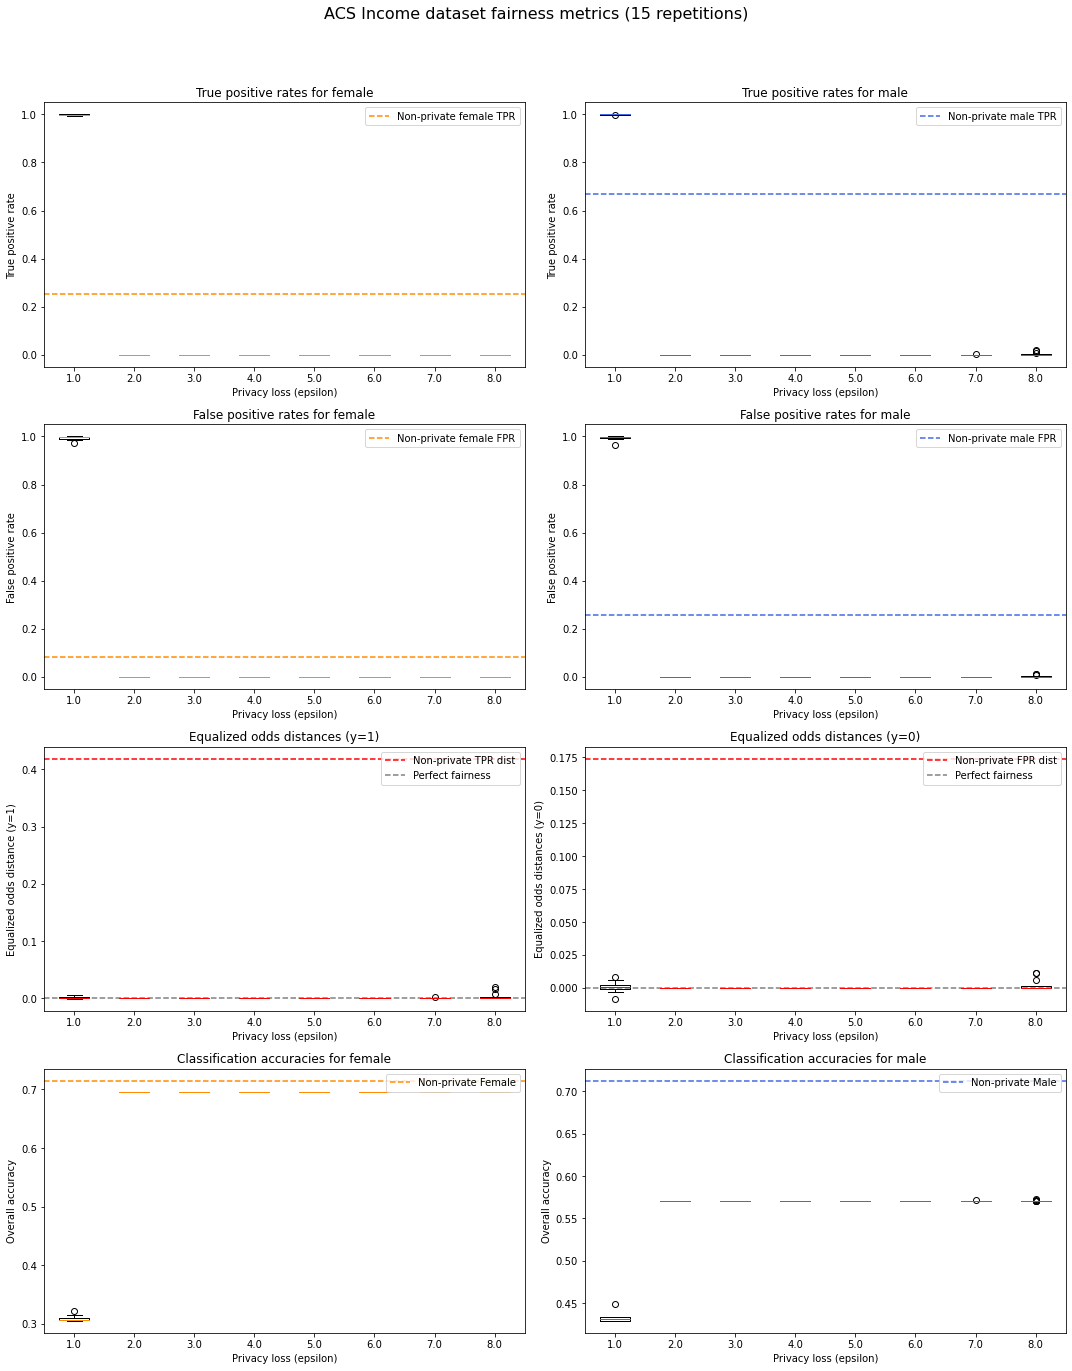

In [35]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_patectgan, plot_non_private=True)

In [36]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_patectgan)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6949
Male Accuracy: 0.5708
Dif in TPR: 0.0
Dif in FPR: 0.0


## 4.7 QUAIL-WRAPPED PATE-CTGAN

In [19]:
# First do epsilons 1 and 2

try:
    # Try to load the dictionary
    acs_income_fairness_quail_patectgan_12 = np.load("acs_income_fairness_quail_patectgan_12.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_patectgan_12 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_patectgan_12.npy", acs_income_fairness_quail_patectgan_12)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=1.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=1.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=1.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=2.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=2.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=2.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=2.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=2.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=2.0, rep=15.


In [20]:
# Epsilons 3 + 4

try:
    # Try to load the dictionary
    acs_income_fairness_quail_patectgan_34 = np.load("acs_income_fairness_quail_patectgan_34.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [3.0, 4.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_patectgan_34 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_patectgan_34.npy", acs_income_fairness_quail_patectgan_34)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=3.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=3.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=4.0, rep=15.


In [21]:
# Epsilons 5+6

try:
    # Try to load the dictionary
    acs_income_fairness_quail_patectgan_56 = np.load("acs_income_fairness_quail_patectgan_56.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [5.0, 6.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_patectgan_56 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_patectgan_56.npy", acs_income_fairness_quail_patectgan_56)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=5.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=6.0, rep=15.


In [22]:
# Epsilons 7+8

try:
    # Try to load the dictionary
    acs_income_fairness_quail_patectgan_78 = np.load("acs_income_fairness_quail_patectgan_78.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 15 repetitions for range of values
    acs_income_fairness_quail_patectgan_78 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="PATECTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("acs_income_fairness_quail_patectgan_78.npy", acs_income_fairness_quail_patectgan_78)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).la

Completed eps=7.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=7.0, rep=15.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=1.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=2.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=3.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=4.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=5.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=6.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=7.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=8.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=9.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=10.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=11.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=12.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=13.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=14.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will res

Completed eps=8.0, rep=15.


In [23]:
# Combine output
acs_income_fairness_quail_patectgan_12 = np.load("acs_income_fairness_quail_patectgan_12.npy", allow_pickle=True).item()
acs_income_fairness_quail_patectgan_34 = np.load("acs_income_fairness_quail_patectgan_34.npy", allow_pickle=True).item()
acs_income_fairness_quail_patectgan_56 = np.load("acs_income_fairness_quail_patectgan_56.npy", allow_pickle=True).item()
acs_income_fairness_quail_patectgan_78 = np.load("acs_income_fairness_quail_patectgan_78.npy", allow_pickle=True).item()


In [28]:
# Join the separate files
acs_income_fairness_quail_patectgan = {**acs_income_fairness_quail_patectgan_12,
                                       **acs_income_fairness_quail_patectgan_34,
                                       **acs_income_fairness_quail_patectgan_56,
                                       **acs_income_fairness_quail_patectgan_78}


In [29]:
# Save combined output
np.save("acs_income_fairness_quail_patectgan.npy", acs_income_fairness_quail_patectgan)

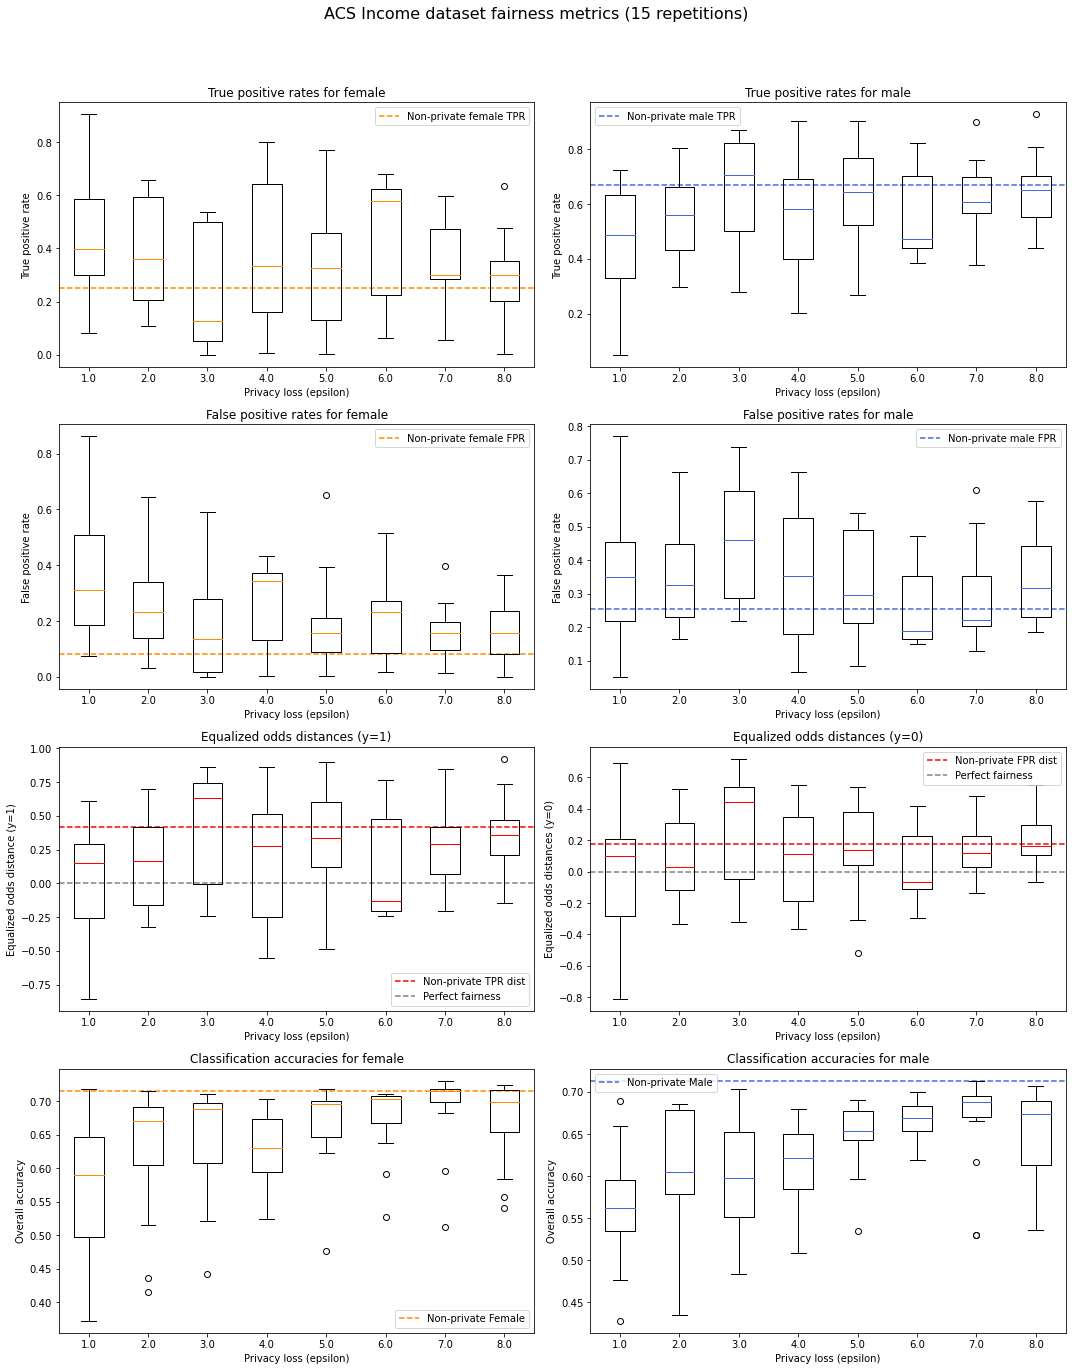

In [30]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(acs_income_fairness_quail_patectgan, plot_non_private=True)

In [31]:
#return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr
epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(acs_income_fairness_quail_patectgan)

print(f'Female Accuracy: {np.round(np.median(acc_f_arr),4)}')
print(f'Male Accuracy: {np.round(np.median(acc_m_arr),4)}')
print(f"Dif in TPR: {np.round(np.median(tpr_diff_arr),4)}") # second
print(f"Dif in FPR: {np.round(np.median(fpr_diff_arr),4)}") # first

Female Accuracy: 0.6897
Male Accuracy: 0.6475
Dif in TPR: 0.2799
Dif in FPR: 0.1316
